In [17]:
# Importaciones básicas y manejo de datos
import pandas as pd
import numpy as np
from math import pi  # Para el gráfico de radar

# Conexión Mongo
from dotenv import load_dotenv
from pymongo import MongoClient


# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning y análisis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Para análisis de correlación y estadísticas
from scipy import stats  # Opcional para análisis estadístico adicional

In [18]:
import os
load_dotenv()
MONGO_URI = os.getenv("CONECTION_DB")

if MONGO_URI:
    print("✅ URI cargada correctamente")
else:
    print("❌ No se encontró la URI")


✅ URI cargada correctamente


In [19]:
import os

def export_mongo_sample_to_csv(
    db_name: str,
    collection_name: str,
    out_csv: str = "dataset_sample.csv",
    sample_size: int = 100000,
    projection: dict | None = None,
):
    # Si ya existe el archivo, lo leemos directo
    if os.path.exists(out_csv):
        print(f"⚠️ El archivo {out_csv} ya existe, cargando en memoria...")
        df = pd.read_csv(out_csv)
        print(f"✅ Cargados {len(df)} registros desde CSV existente")
        return df

    # Si no existe, conectamos a Mongo y generamos muestra
    mongo_uri = os.getenv("CONECTION_DB")
    client = MongoClient(mongo_uri)
    col = client[db_name][collection_name]

    pipeline = [{"$sample": {"size": sample_size}}]
    if projection:
        pipeline.append({"$project": projection})

    cursor = col.aggregate(pipeline)
    data = list(cursor)

    df = pd.json_normalize(data)
    df.to_csv(out_csv, index=False)
    client.close()
    print(f"✅ Nueva muestra guardada en {out_csv} con {len(df)} registros")
    return df


In [20]:
df = export_mongo_sample_to_csv(
    db_name="luminarias",
    collection_name="luminarias",
    out_csv="dataset_sample.csv",
    sample_size=5000
)
df.head()


⚠️ El archivo dataset_sample.csv ya existe, cargando en memoria...


✅ Cargados 5000 registros desde CSV existente


,_id,identificador,tipo,potencia_watts,altura_metros,estado,createdAt,updatedAt,ubicacion.direccion,ubicacion.coordenadas.lat,...,mantenimiento.notas,mantenimiento.responsable,conectividad.estado_red,conectividad.latencia_ms,conectividad.firmware,eficiencia.lumens_por_watt,eficiencia.horas_funcionamiento_total,eficiencia.vida_util_restante_pct,registro.fecha_instalacion,registro.creado_por
0,685e064ffc791db76e142603,coahtor11041510466962,Halógena,150,6.32,fallando,2025-06-27 02:47:45.934,2025-06-27 02:47:45.934,"7399 Perez Valley Suite 936\nDeborahfort, VT 5...",15.620696,...,Analysis support yard life.,Elías Acosta,sin conexión,37.6,v1.2.3,99.86,5165,38.3,2025-04-11,admin_sistema
1,685e07c5fc791db76e395b26,jalgd10031698873361,LED,75,7.74,fallando,2025-06-27 02:54:02.193,2025-06-27 02:54:02.193,"716 James Neck\nJessestad, MO 73476",16.475836,...,Entire over dream change mouth.,Andrea Cabrera,inestable,30.5,v1.2.3,96.50,4377,57.8,2025-03-10,admin_sistema
2,685e09f4fc791db76e45ba4f,grochil151223948491,Incandescente,150,6.99,apagada,2025-06-27 03:03:18.893,2025-06-27 03:03:18.893,"74395 David Mission\nGilesmouth, NM 33942",23.412382,...,Boy authority hotel.,Brenda Palma,estable,67.5,v1.2.3,128.26,2653,86.9,2024-12-15,admin_sistema
3,685e0730fc791db76e28c08c,naytep22122094692005,LED,150,9.91,fallando,2025-06-27 02:51:33.779,2025-06-27 02:51:33.779,"70045 Adams Square\nHallshire, MI 97515",20.671628,...,Conference argue skill food federal theory cam...,Luis López,inestable,80.5,v1.0.0,120.72,9719,52.7,2024-12-22,admin_sistema
4,685e068bfc791db76e1a864c,campcam23102194536605,LED,100,8.00,encendida,2025-06-27 02:48:46.443,2025-06-27 02:48:46.443,"95337 Andrew Mountain Apt. 818\nMedinamouth, C...",21.848591,...,Evening get sport choice station place nation.,Abel Márquez,estable,32.2,v1.2.3,112.90,647,40.3,2024-10-23,admin_sistema


In [21]:
# Carga y preparacion de datos

# Cargar los datos
df = pd.read_csv("dataset_sample.csv")

# Seleccionar características relevantes para el clustering
features = [
    "potencia_watts",
    "altura_metros",
    "consumo.actual_watts",
    "consumo.acumulado_kwh.mes",
    "sensores.luminosidad_lux",
    "sensores.temperatura_c",
    "sensores.humedad_pct",
    "conectividad.latencia_ms",
    "eficiencia.lumens_por_watt",
    "eficiencia.horas_funcionamiento_total",
    "eficiencia.vida_util_restante_pct"
]

# Limpieza de datos
df_clean = df.dropna(subset=features)
X = df_clean[features]

# Estandarización de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



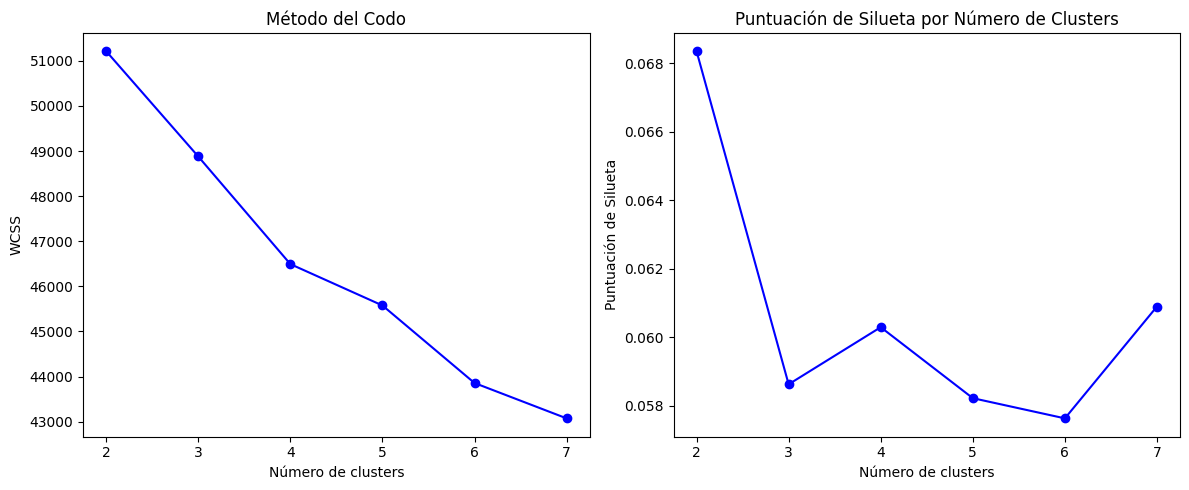

In [22]:
# Determinación del número óptimo de clusters
# Método del codo para determinar el número óptimo de clusters
wcss = []
silhouette_scores = []
range_n_clusters = range(2, 8)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Graficar el método del codo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, wcss, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método del Codo')

# Graficar puntuaciones de silueta
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Puntuación de Silueta')
plt.title('Puntuación de Silueta por Número de Clusters')
plt.tight_layout()
plt.show()

In [23]:
#Aplicación de K-Means con el número óptimo de clusters
# Elegir el número óptimo de clusters basado en los gráficos
optimal_clusters = 3  

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Añadir los clusters al dataframe
df_clean['cluster'] = clusters

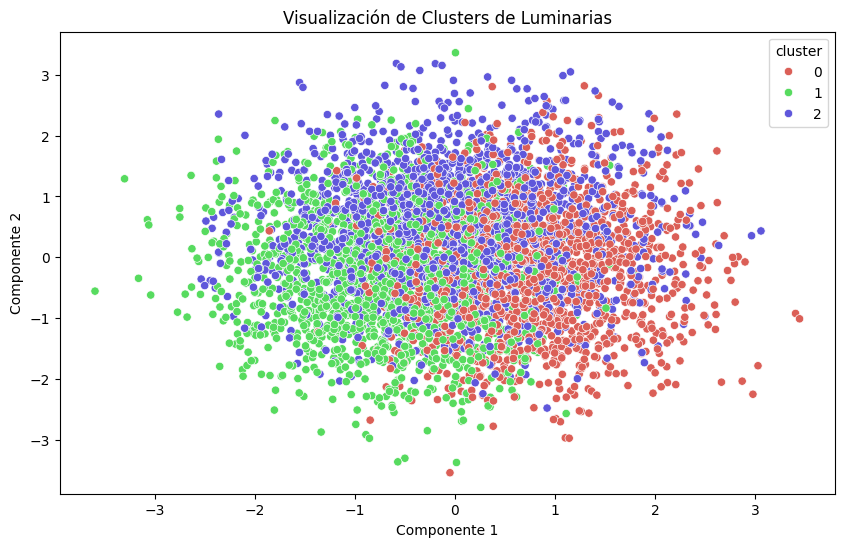

In [24]:
#Visualizacion
# Reducción de dimensionalidad para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Crear dataframe para visualización
df_viz = pd.DataFrame(X_pca, columns=['Componente 1', 'Componente 2'])
df_viz['cluster'] = clusters

# Visualizar clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Componente 1', y='Componente 2',
    hue='cluster', 
    palette=sns.color_palette("hls", optimal_clusters),
    data=df_viz,
    legend="full"
)
plt.title('Visualización de Clusters de Luminarias')
plt.show()

Características promedio por cluster:
         potencia_watts  altura_metros  consumo.actual_watts  \
cluster                                                        
0             94.066970       7.212750             70.482893   
1             89.625315       7.294723             77.026304   
2             95.024013       9.196206             75.837668   

         consumo.acumulado_kwh.mes  sensores.luminosidad_lux  \
cluster                                                        
0                        39.465897                237.960338   
1                        38.675258                107.977960   
2                        40.881574                176.050160   

         sensores.temperatura_c  sensores.humedad_pct  \
cluster                                                 
0                     26.993433             59.384525   
1                     28.132557             59.922481   
2                     27.387300             60.035272   

         conectividad.latencia_ms 

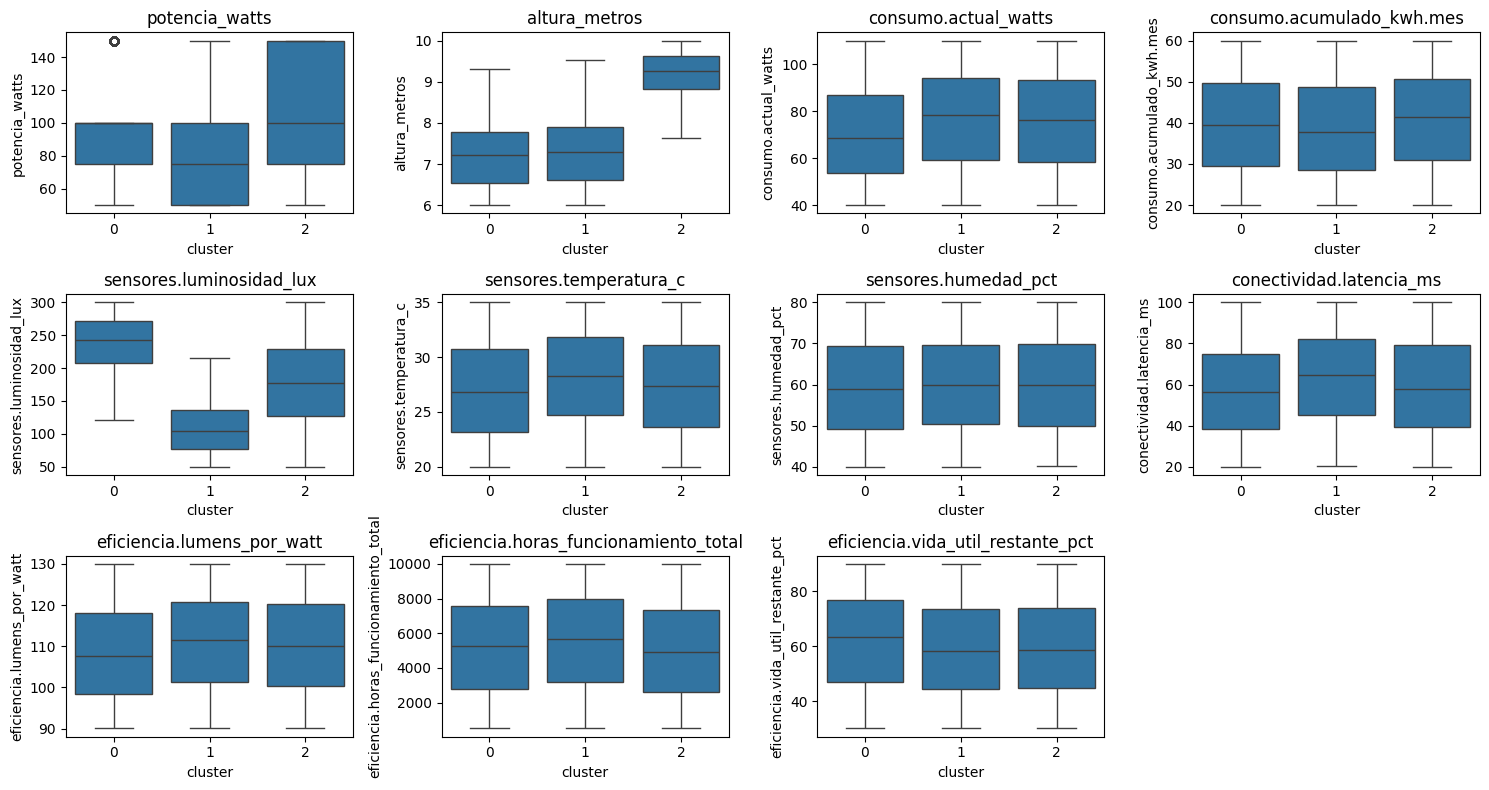

In [25]:
#Analisis de Clusters
# Estadísticas descriptivas por cluster
cluster_stats = df_clean.groupby('cluster')[features].mean()

# Mostrar estadísticas
print("Características promedio por cluster:")
print(cluster_stats)

# Visualización de características importantes por cluster
plt.figure(figsize=(15, 8))
for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.boxplot(x='cluster', y=feature, data=df_clean)
    plt.title(feature)
plt.tight_layout()
plt.show()

In [26]:
#Interpretacion de clusters
# Interpretar los clusters basado en las características
cluster_interpretation = {
    0: "Luminarias de alto consumo y baja eficiencia",
    1: "Luminarias eficientes con buen estado",
    2: "Luminarias con problemas de conectividad y mantenimiento"
}

df_clean['cluster_interpretation'] = df_clean['cluster'].map(cluster_interpretation)

# Mostrar distribución de clusters
print("\nDistribución de clusters:")
print(df_clean['cluster_interpretation'].value_counts())

# Guardar resultados para el frontend
df_clean.to_csv('luminarias_clusters.csv', index=False)


Distribución de clusters:
cluster_interpretation
Luminarias con problemas de conectividad y mantenimiento    1874
Luminarias eficientes con buen estado                       1588
Luminarias de alto consumo y baja eficiencia                1538
Name: count, dtype: int64


## 3. Gráfico de Barras Apiladas por Estado de Mantenimiento


<Figure size 1000x600 with 0 Axes>

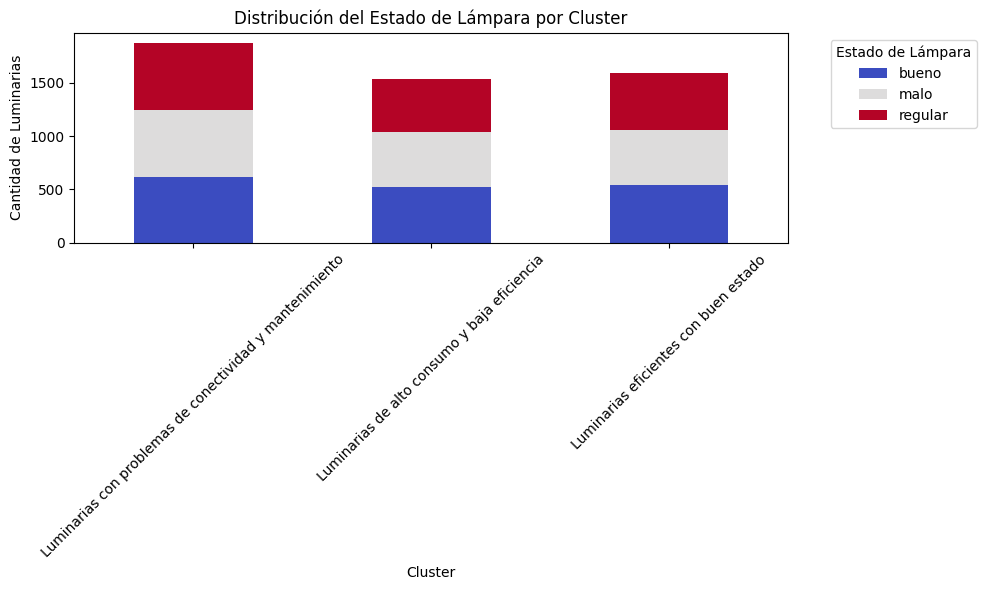

In [27]:
# Crear gráfico de barras apiladas por estado de mantenimiento
plt.figure(figsize=(10, 6))
cross_tab = pd.crosstab(df_clean['cluster_interpretation'], 
                        df_clean['mantenimiento.estado_lampara'])
cross_tab.plot(kind='bar', stacked=True, figsize=(10,6), 
               colormap='coolwarm')
plt.title('Distribución del Estado de Lámpara por Cluster')
plt.ylabel('Cantidad de Luminarias')
plt.xlabel('Cluster')
plt.xticks(rotation=45)
plt.legend(title='Estado de Lámpara', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [28]:
# Exportar el DataFrame con los clusters a JSON
df_clean.to_json('luminarias_clusters.json', orient='records', indent=4)
print("✅ Datos exportados a 'luminarias_clusters.json'")

✅ Datos exportados a 'luminarias_clusters.json'
